In [1]:
import os
import pandas as pd
import numpy as np
import scipy
import glob
import math
import matplotlib.pyplot as plt
from operator import *
import gc

import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

from scipy.signal import butter, lfilter

import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Filtering functions
def butter_bandpass(lowcut, highcut, fs, order=6):
  return butter(order, [lowcut, highcut], fs=fs, btype='band')
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data)
  return y
def calcsnr(prefilter, filtered):
  filteredsum = 0
  denomsum = 0
  for i in range(len(prefilter)):
    filteredsum = filteredsum+filtered[i]*filtered[i]
    denomsum = denomsum+ (filtered[i]-prefilter[i])*(filtered[i]-prefilter[i])
  return 10*math.log10(filteredsum/denomsum)

# Custom dataset object
class EEGDataset(Dataset):
  def __init__(self, eeglist, labels, transform=None, target_transform=None):
    self.labels = torch.from_numpy(np.array(labels))
    self.labels = self.labels.to(torch.float32)
    self.eeglist = eeglist
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):

    label = self.labels[idx]
    raw = self.eeglist[idx]
    eeg = torch.from_numpy(raw.get_data())
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return eeg, label

# Collect Raw objects from MNE in Python lists
data_list = {"raw":[], "preprocessed":[], "manual_preprocess":[], "rawsample": [], "preprocessedsample":[], "manual_preprocesssample":[]}
labels = []

# Get subject information
readtsv = pd.read_csv('participants.tsv', sep = '\t')

# Channel names, taken from OpenNeuro
channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

# Parse in .set files
for i in range(1,89):

  filteredpath = r"\\VSRV1\B.Homes$\bhutanig\Documents\EEG-Alzheimer-Detection\OpenNeuro Preprocessed\sub-%s\eeg"%(str(i).zfill(3))
  filteredfile = glob.glob(os.path.join(filteredpath, '*.set'))
  filtered = mne.io.read_raw_eeglab(filteredfile[0], preload = True)

  rawpath = r"\\VSRV1\B.Homes$\bhutanig\Documents\EEG-Alzheimer-Detection\Raw Data\sub-%s\eeg"%(str(i).zfill(3))
  file = glob.glob(os.path.join(rawpath, '*.set'))
  raw = mne.io.read_raw_eeglab(file[0], preload = True)

  # Update data lists
  data_list['raw'].append(raw)
  data_list['preprocessed'].append(filtered)

  label = readtsv['Group'][i-1]
  # Change labels to onehot encodings
  if label == 'A':
    labels.append([0,0,1])
  elif label == 'F':
    labels.append([0,1,0])
  elif label == 'C':
    labels.append([1,0,0])


C:\Users\bhutanig\AppData\Local\Temp\ipykernel_25840\1886153275.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  filtered = mne.io.read_raw_eeglab(filteredfile[0], preload = True)
C:\Users\bhutanig\AppData\Local\Temp\ipykernel_25840\1886153275.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  filtered = mne.io.read_raw_eeglab(filteredfile[0], preload = True)
C:\Users\bhutanig\AppData\Local\Temp\ipykernel_25840\1886153275.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  filtered = mne.io.read_raw_eeglab(filteredfile[0], preload = True)
C:\Users\bhutanig\AppData\Local\Temp\ipykernel_25840\1886153275.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data disco

In [2]:
from mne_icalabel import label_components
exclusion = ['line noise', 'heartbeat', 'eye blink']

def manual_process(raw, plotting = True):
    freq_low = 0.5
    freq_high = 45
    iirparams = dict(order = 4, ftype = 'butter')

    raw.filter(freq_low, freq_high, method = 'iir', iir_params = iirparams)

    # Create ICA object and fit it to the data
    ica = ICA(n_components=19, random_state=97, verbose = False)
    ica.fit(raw)

    # Plot ICA components to identify artifacts
    icalabels = label_components(raw, ica, method = 'iclabel')
    if plotting == True:
        ica.plot_components()
        picks = list(range(0,18))
        ica.plot_properties(raw, picks=picks)
        print(icalabels)
    ica.exclude = []
    for i, label in enumerate(icalabels):
        if label in exclusion:
            ica.exclude.append(i)
    ica.apply(raw)
            
    return raw

In [3]:
from IPython.display import clear_output 
i = 0
for subject in data_list['raw']:
    raw = subject.copy().load_data()
    data_list['manual_preprocess'].append(manual_process(raw, plotting = False))
    clear_output()
    i+=1
    print(i)


88


In [4]:
import gc
gc.collect()
totals = [485.5, 276.5, 402]
trainlist, vallist, testlist, trainlabels, vallabels, testlabels = [],[],[],[],[],[]
labelonehot = [[0,0,1], [0,1,0], [1,0,0]]
#make sure enough of each group in each partition of data
for x, label in enumerate(labelonehot):
  count = 0
  for i in range (len(labels)):
    if labels[i] == label:
      m = 0
      # print(len(n.get_data()[0]))
      while 15000*(m+1) < len(data_list['manual_preprocess'][i].copy().get_data()[0]):
        if totals[x]*2-count>120:
          n = data_list['manual_preprocess'][i].copy()
          trainlist.append(n.crop(m*30,(m+1)*30))
          trainlabels.append(labels[i])
        if totals[x]*2-count>40:
          n = data_list['manual_preprocess'][i].copy()
          vallist.append(n.crop(m*30,(m+1)*30))
          vallabels.append(labels[i])
        else:
          n = data_list['manual_preprocess'][i].copy()
          testlist.append(n.crop(m*30, (m+1)*30))
          testlabels.append(labels[i])
        count = count + 1
        m = m+1


trainset = EEGDataset(trainlist, trainlabels)
valset = EEGDataset(vallist, vallabels)
testset = EEGDataset(testlist, testlabels)

trainloader = DataLoader(trainset, batch_size = 127, shuffle = True)
valloader = DataLoader(valset, batch_size = 127, shuffle = True)
testloader = DataLoader(testset, batch_size = 127, shuffle = True)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class CNN_EEG_Classifier(nn.Module):
    def __init__(self):
        super(CNN_EEG_Classifier, self).__init__()
        #USE LARGER KERNEL BECAUSE IMAGES ARE HIGH RESOLUTION, FEATURES TAKE UP MORE PIXELS
        self.conv1 = nn.Conv1d(19, 25, 2) 
        
        #BATCH NORMALIZATION TO PREVENT VANISHING GRADIENTS
        self.bn1 = nn.BatchNorm1d(25)
        #LARGE POOLING KERNEL TO REDUCE DIMENSIONALIZATION FASTER (JUST FOUND THIS TO BE HELPFUL BY EXPERIMENTING)
        self.pool = nn.MaxPool1d(4, 4)

        self.conv2 = nn.Conv1d(25, 30, 2) 

        self.bn2 = nn.BatchNorm1d(30)
        self.fc1 = nn.Linear(28110, 256)
        self.fc2 = nn.Linear(256, 3)


    def forward(self, x):
        batch_size = x.shape[0]
        outconv1 = self.pool(F.relu(self.bn1(self.conv1(x))))
        outconv2 = self.pool(F.relu(self.bn2(self.conv2(outconv1))))

        outconv2 = outconv2.view(batch_size, -1)

        outfc1 = F.relu(self.fc1(outconv2))
        # print(outfc1.shape)

        outfc2 = self.fc2(outfc1)
        # print(outfc2.shape)

        out = F.softmax(outfc2, dim = 1)
        print(out.shape)

        return out

class CNN_EEG_Classifier_lstm(nn.Module):
    def __init__(self):
        super(CNN_EEG_Classifier_lstm, self).__init__()
        #USE LARGER KERNEL BECAUSE IMAGES ARE HIGH RESOLUTION, FEATURES TAKE UP MORE PIXELS
        self.conv1 = nn.Conv1d(19, 25, 2) 
        
        #BATCH NORMALIZATION TO PREVENT VANISHING GRADIENTS
        self.bn1 = nn.BatchNorm1d(25)
        #LARGE POOLING KERNEL TO REDUCE DIMENSIONALIZATION FASTER (JUST FOUND THIS TO BE HELPFUL BY EXPERIMENTING)
        self.pool = nn.MaxPool1d(4, 4)

        self.conv2 = nn.Conv1d(25, 30, 2) 

        self.bn2 = nn.BatchNorm1d(30)

        self.hidden_size = 100
        self.lstm = nn.LSTM(30, self.hidden_size, 1, batch_first = True)

        self.fc1 = nn.Linear(28110, 256)
        self.fc2 = nn.Linear(256, 3)


    def forward(self, x):
        batch_size = x.shape[0]
        outconv1 = self.pool(F.relu(self.bn1(self.conv1(x))))
        outconv2 = self.pool(F.relu(self.bn2(self.conv2(outconv1))))

        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # print(x.shape, h0.shape, c0.shape)
        outlstm = outconv2.permute(0, 2, 1)
        outlstm, _ = self.lstm(outlstm, (h0, c0))
        outlstm = outlstm[:, -1, :]
        outlstm = outlstm.view(batch_size, -1)

        outfc1 = F.relu(self.fc1(outlstm))

        # print(outfc1.shape)

        outfc2 = self.fc2(outfc1)
        # print(outfc2.shape)

        out = F.softmax(outfc2, dim = 1)

        return out

class CNN_EEG_Classifier_dropout(nn.Module):
    def __init__(self):
        super(CNN_EEG_Classifier_dropout, self).__init__()
        #USE LARGER KERNEL BECAUSE IMAGES ARE HIGH RESOLUTION, FEATURES TAKE UP MORE PIXELS
        self.conv1 = nn.Conv1d(19, 25, 2) 
        
        #BATCH NORMALIZATION TO PREVENT VANISHING GRADIENTS
        self.bn1 = nn.BatchNorm1d(25)
        #LARGE POOLING KERNEL TO REDUCE DIMENSIONALIZATION FASTER (JUST FOUND THIS TO BE HELPFUL BY EXPERIMENTING)
        self.pool = nn.MaxPool1d(4, 4)

        self.conv2 = nn.Conv1d(25, 30, 2) 

        self.bn2 = nn.BatchNorm1d(30)

        self.fc1 = nn.Linear(28110, 10000)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10000, 1000)
        self.dropout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(1000, 100)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(100, 3)



    def forward(self, x):
        batch_size = x.shape[0]
        outconv1 = self.pool(F.relu(self.bn1(self.conv1(x))))
        outconv2 = self.pool(F.relu(self.bn2(self.conv2(outconv1))))

        outconv2 = outconv2.view(batch_size, -1)

        outfc1 = self.dropout1(F.relu(self.fc1(outconv2)))

        # print(outfc1.shape)

        outfc2 = self.dropout2(self.fc2(outfc1))
        # print(outfc2.shape)

        outfc3 = self.dropout3(F.relu(self.fc3(outfc2)))
        outfc4 = self.fc4(outfc3)
        out = F.softmax(outfc4, dim = 1)

        return out

class CNN_EEG_Classifier_linear1(nn.Module):
    def __init__(self):
        super(CNN_EEG_Classifier_linear1, self).__init__()
        #USE LARGER KERNEL BECAUSE IMAGES ARE HIGH RESOLUTION, FEATURES TAKE UP MORE PIXELS
        self.conv1 = nn.Conv1d(19, 25, 2) 
        
        #BATCH NORMALIZATION TO PREVENT VANISHING GRADIENTS
        self.bn1 = nn.BatchNorm1d(25)
        #LARGE POOLING KERNEL TO REDUCE DIMENSIONALIZATION FASTER (JUST FOUND THIS TO BE HELPFUL BY EXPERIMENTING)
        self.pool = nn.MaxPool1d(4, 4)

        self.conv2 = nn.Conv1d(25, 30, 2) 

        self.bn2 = nn.BatchNorm1d(30)

        self.fc1 = nn.Linear(28110, 10000)
        self.fc2 = nn.Linear(10000, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.dropout1 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(100, 3)



    def forward(self, x):
        batch_size = x.shape[0]
        outconv1 = self.pool(F.relu(self.bn1(self.conv1(x))))
        outconv2 = self.pool(F.relu(self.bn2(self.conv2(outconv1))))

        outconv2 = outconv2.view(batch_size, -1)

        outfc1 = (F.relu(self.fc1(outconv2)))

        # print(outfc1.shape)

        outfc2 = (self.fc2(outfc1))
        # print(outfc2.shape)

        outfc3 = self.dropout1(F.relu(self.fc3(outfc2)))
        outfc4 = self.fc4(outfc3)
        out = F.softmax(outfc4, dim = 1)

        return out

class CNN_EEG_Classifier_linear2(nn.Module):
    def __init__(self, conv1_kernel_size = 2, conv2_kernel_size = 2, conv1_size = 25, conv2_size = 30, pool_kernel = 2, pool_stride = 2, conv1_stride = 1, conv2_stride = 1):
        """Average Pool, Pool size 2"""
        super(CNN_EEG_Classifier_linear2, self).__init__()
        #USE LARGER KERNEL BECAUSE IMAGES ARE HIGH RESOLUTION, FEATURES TAKE UP MORE PIXELS
        self.conv1 = nn.Conv1d(19, conv1_size, conv1_kernel_size) 
        size1 = ((15001-conv1_kernel_size)/conv1_stride) + 1
        #BATCH NORMALIZATION TO PREVENT VANISHING GRADIENTS
        self.bn1 = nn.BatchNorm1d(conv1_size)
        #LARGE POOLING KERNEL TO REDUCE DIMENSIONALIZATION FASTER (JUST FOUND THIS TO BE HELPFUL BY EXPERIMENTING)
        self.pool = nn.AvgPool1d(pool_kernel, pool_stride)
        size1_pool = ((size1 - pool_kernel)/pool_stride) + 1

        self.conv2 = nn.Conv1d(conv1_size, conv2_size, conv2_kernel_size) 
        size2 = ((size1_pool-conv2_kernel_size)/conv2_stride) + 1
        size2_pool = ((size2 - pool_kernel)//pool_stride) + 1

        self.bn2 = nn.BatchNorm1d(conv2_size)

        size1_flatten = size2_pool*conv2_size
        linear1_size = int(size1_flatten)

        self.fc1 = nn.Linear(linear1_size, 10000)
        self.fc2 = nn.Linear(10000, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.dropout1 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(100, 3)



    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        outconv1 = self.pool(F.relu(self.bn1(self.conv1(x))))
        # print(outconv1.shape)
        outconv2 = self.pool(F.relu(self.bn2(self.conv2(outconv1))))
        # print(outconv2.shape)
        outconv2 = outconv2.view(batch_size, -1)
        # print(outconv2.shape)
        outfc1 = (F.relu(self.fc1(outconv2)))

        outfc2 = (self.fc2(outfc1))

        outfc3 = self.dropout1(F.relu(self.fc3(outfc2)))
        outfc4 = self.fc4(outfc3)
        out = F.softmax(outfc4, dim = 1)

        return out
    
class CNN_EEG_Classifier_linear3(nn.Module):
    def __init__(self, conv1_kernel_size = 2, conv2_kernel_size = 2, conv1_size = 25, conv2_size = 30, pool_kernel = 2, pool_stride = 2, conv1_stride = 1, conv2_stride = 1):
        """Max Pool, Pool size 2"""
        super(CNN_EEG_Classifier_linear3, self).__init__()
        #USE LARGER KERNEL BECAUSE IMAGES ARE HIGH RESOLUTION, FEATURES TAKE UP MORE PIXELS
        self.conv1 = nn.Conv1d(19, conv1_size, conv1_kernel_size) 
        size1 = ((15001-conv1_kernel_size)/conv1_stride) + 1
        #BATCH NORMALIZATION TO PREVENT VANISHING GRADIENTS
        self.bn1 = nn.BatchNorm1d(conv1_size)
        #LARGE POOLING KERNEL TO REDUCE DIMENSIONALIZATION FASTER (JUST FOUND THIS TO BE HELPFUL BY EXPERIMENTING)
        self.pool = nn.MaxPool1d(pool_kernel, pool_stride)
        size1_pool = ((size1 - pool_kernel)/pool_stride) + 1

        self.conv2 = nn.Conv1d(conv1_size, conv2_size, conv2_kernel_size) 
        size2 = ((size1_pool-conv2_kernel_size)/conv2_stride) + 1
        size2_pool = ((size2 - pool_kernel)//pool_stride) + 1

        self.bn2 = nn.BatchNorm1d(conv2_size)

        size1_flatten = size2_pool*conv2_size
        linear1_size = int(size1_flatten)

        self.fc1 = nn.Linear(linear1_size, 10000)
        self.fc2 = nn.Linear(10000, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.dropout1 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(100, 3)



    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        outconv1 = self.pool(F.relu(self.bn1(self.conv1(x))))
        # print(outconv1.shape)
        outconv2 = self.pool(F.relu(self.bn2(self.conv2(outconv1))))
        # print(outconv2.shape)
        outconv2 = outconv2.view(batch_size, -1)
        # print(outconv2.shape)
        outfc1 = (F.relu(self.fc1(outconv2)))

        outfc2 = (self.fc2(outfc1))

        outfc3 = self.dropout1(F.relu(self.fc3(outfc2)))
        outfc4 = self.fc4(outfc3)
        out = F.softmax(outfc4, dim = 1)

        return out
    
class CNN_LSTM_EEG(nn.Module):
    def __init__(self):
        super(CNN_LSTM_EEG, self).__init__()
        # This is taking in 64 channels from what I understand, we could change it to 19
        self.conv1 = nn.Conv1d(19, 64, kernel_size = 3, stride = 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, kernel_size = 3, stride = 1)
        self.bn2 = nn.BatchNorm1d(64)
        # self.conv1 = nn.Conv2d(1, 64, kernel_size = (1,3), stride = 1)
        # self.conv2 = nn.Conv2d(64, 64, kernel_size = (1, 3), stride = 1)
        # print("SHAPE =", self.conv1.weight.shape)
        self.dropout1 = nn.Dropout(0.5)
        self.pool = nn.MaxPool1d(kernel_size = 2, stride = 2)
        
        self.flatten = nn.Flatten() # Rad removed this line
        self.hidden_size = 100
        self.lstm = nn.LSTM(64, self.hidden_size, 1, batch_first = True)
        
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(100, 100)
        self.dropout3 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(100, 50)
        self.dropout4 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, x):
        # print(x.shape)
        x = F.relu(self.bn1(self.conv1(x)))
        # print(x.shape)
        x = (self.pool(self.dropout1(F.relu(self.bn1(self.conv2(x))))))
        # print(x.shape)
        # x = self.flatten(x)
        # print(x.shape)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # print(x.shape, h0.shape, c0.shape)
        print(x.shape)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x, (h0, c0))
        print(x.shape)
        x = self.dropout2(x[:, -1, :])
        x = self.fc1(x)
        x = self.dropout3(x)
        x = self.fc2(F.relu(x))
        x = self.dropout4(x)
        x = self.fc3(F.sigmoid(x))
        print(x.shape)

        return x

class CNN_EEG_Classifier_linear_cnn_extra(nn.Module):
    def __init__(self):
        """MORE CNNs, MORE LAYERS, MORE POWER"""
        super(CNN_EEG_Classifier_linear_cnn_extra, self).__init__()
        
        
        conv_size = [25, 30, 35, 40, 50]
        conv_stride = [1, 1, 1, 1, 1]
        conv_kernel_size = [2, 2, 2, 2, 2]
        n_layers = len(conv_size)
        
        pool_kernel = 4
        pool_stride = 4
        
        
        self.conv1 = nn.Conv1d(19, conv_size[0], conv_kernel_size[0], conv_stride[0])
        self.bn1 = nn.BatchNorm1d(conv_size[0])
        self.conv2 = nn.Conv1d(conv_size[0], conv_size[1], conv_kernel_size[1], conv_stride[1])
        self.bn2 = nn.BatchNorm1d(conv_size[1])
        self.conv3 = nn.Conv1d(conv_size[1], conv_size[2], conv_kernel_size[2], conv_stride[2])
        self.bn3 = nn.BatchNorm1d(conv_size[2])
        self.conv4 = nn.Conv1d(conv_size[2], conv_size[3], conv_kernel_size[3], conv_stride[3])
        self.bn4 = nn.BatchNorm1d(conv_size[3])
        self.conv5 = nn.Conv1d(conv_size[3], conv_size[4], conv_kernel_size[4], conv_stride[4])
        self.bn5 = nn.BatchNorm1d(conv_size[4])
        
        self.pool = nn.MaxPool1d(pool_kernel, pool_stride)
        
        size = 15001
        for i in range(n_layers):
            size = ((size-conv_kernel_size[i])/conv_stride[i]) + 1
            size = ((size - pool_kernel)//pool_stride) + 1  
        
        linear1_size = int(size*conv_size[n_layers-1])
        print(linear1_size)
        self.fc1 = nn.Linear(linear1_size, 5000)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.dropout1 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(100, 3)



    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        outconv1 = self.pool(F.relu(self.bn1(self.conv1(x))))
        # print(outconv1.shape)
        outconv2 = self.pool(F.relu(self.bn2(self.conv2(outconv1))))
        outconv3 = self.pool(F.relu(self.bn3(self.conv3(outconv2))))
        outconv4 = self.pool(F.relu(self.bn4(self.conv4(outconv3))))
        outconv5 = self.pool(F.relu(self.bn5(self.conv5(outconv4))))
        # print(outconv2.shape)
        outconv5 = outconv5.view(batch_size, -1)
        # print(outconv2.shape)
        outfc1 = (F.relu(self.fc1(outconv2)))

        outfc2 = (self.fc2(outfc1))

        outfc3 = self.dropout1(F.relu(self.fc3(outfc2)))
        outfc4 = self.fc4(outfc3)
        out = F.softmax(outfc4, dim = 1)

        return out


class CNN_EEG_Classifier_linear_cnn_extra_pool_less(nn.Module):
    def __init__(self):
        """MORE CNNs, MORE LAYERS, MORE POWER"""
        super(CNN_EEG_Classifier_linear_cnn_extra_pool_less, self).__init__()
        
        
        conv_size = [25, 30, 35, 40, 50]
        conv_stride = [1, 1, 1, 1, 1]
        conv_kernel_size = [2, 2, 2, 2, 2]
        n_layers = len(conv_size)
        
        pool_kernel = [4, 1, 4, 1, 4]
        pool_stride = [4, 1, 4, 1, 4]
        
        
        self.conv1 = nn.Conv1d(19, conv_size[0], conv_kernel_size[0], conv_stride[0])
        self.bn1 = nn.BatchNorm1d(conv_size[0])
        self.pool1 = nn.MaxPool1d(pool_kernel[0], pool_stride[0])

        self.conv2 = nn.Conv1d(conv_size[0], conv_size[1], conv_kernel_size[1], conv_stride[1])
        self.bn2 = nn.BatchNorm1d(conv_size[1])
        self.pool2 = nn.MaxPool1d(pool_kernel[1], pool_stride[1])

        self.conv3 = nn.Conv1d(conv_size[1], conv_size[2], conv_kernel_size[2], conv_stride[2])
        self.bn3 = nn.BatchNorm1d(conv_size[2])
        self.pool3 = nn.MaxPool1d(pool_kernel[2], pool_stride[2])

        self.conv4 = nn.Conv1d(conv_size[2], conv_size[3], conv_kernel_size[3], conv_stride[3])
        self.bn4 = nn.BatchNorm1d(conv_size[3])
        self.pool4 = nn.MaxPool1d(pool_kernel[3], pool_stride[3])

        self.conv5 = nn.Conv1d(conv_size[3], conv_size[4], conv_kernel_size[4], conv_stride[4])
        self.bn5 = nn.BatchNorm1d(conv_size[4])
        self.pool5 = nn.MaxPool1d(pool_kernel[4], pool_stride[4])
        
        
        
        size = 15001
        for i in range(n_layers):
            size = ((size-conv_kernel_size[i])/conv_stride[i]) + 1
            size = ((size - pool_kernel[i])//pool_stride[i]) + 1  
            # print(size)
        
        linear1_size = int(size*conv_size[n_layers-1])
        # print(linear1_size)
        self.fc1 = nn.Linear(linear1_size, 5000)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.dropout1 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(100, 3)



    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        outconv1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # print(outconv1.shape)
        outconv2 = self.pool2(F.relu(self.bn2(self.conv2(outconv1))))
        # print(outconv2.shape)
        outconv3 = self.pool3(F.relu(self.bn3(self.conv3(outconv2))))
        # print(outconv3.shape)
        outconv4 = self.pool4(F.relu(self.bn4(self.conv4(outconv3))))
        # print(outconv4.shape)
        outconv5 = self.pool5(F.relu(self.bn5(self.conv5(outconv4))))
        # print(outconv5.shape)
        outconv5 = outconv5.view(batch_size, -1)
        # print(outconv5.shape)
        outfc1 = (F.relu(self.fc1(outconv5)))

        outfc2 = (self.fc2(outfc1))

        outfc3 = self.dropout1(F.relu(self.fc3(outfc2)))
        outfc4 = self.fc4(outfc3)
        out = F.softmax(outfc4, dim = 1)

        return out
    

class CNN_EEG_Classifier_3cnn(nn.Module):
    def __init__(self):
        """MORE CNNs, MORE LAYERS, MORE POWER
        That was a lie"""
        super(CNN_EEG_Classifier_3cnn, self).__init__()
        
        
        conv_size = [25, 30, 35]
        conv_stride = [1, 1, 1]
        conv_kernel_size = [2, 2, 2]
        n_layers = len(conv_size)
        
        pool_kernel = [1, 4, 1]
        pool_stride = [1, 4, 1]
        
        
        self.conv1 = nn.Conv1d(19, conv_size[0], conv_kernel_size[0], conv_stride[0])
        self.bn1 = nn.BatchNorm1d(conv_size[0])
        self.pool1 = nn.MaxPool1d(pool_kernel[0], pool_stride[0])

        self.conv2 = nn.Conv1d(conv_size[0], conv_size[1], conv_kernel_size[1], conv_stride[1])
        self.bn2 = nn.BatchNorm1d(conv_size[1])
        self.pool2 = nn.MaxPool1d(pool_kernel[1], pool_stride[1])

        self.conv3 = nn.Conv1d(conv_size[1], conv_size[2], conv_kernel_size[2], conv_stride[2])
        self.bn3 = nn.BatchNorm1d(conv_size[2])
        self.pool3 = nn.MaxPool1d(pool_kernel[2], pool_stride[2])
        
        size = 15001
        for i in range(n_layers):
            size = ((size-conv_kernel_size[i])/conv_stride[i]) + 1
            size = ((size - pool_kernel[i])//pool_stride[i]) + 1  
            # print(size)
        
        linear1_size = int(size*conv_size[n_layers-1])
        # print(linear1_size)
        self.fc1 = nn.Linear(linear1_size, 7500)
        self.fc2 = nn.Linear(7500, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.dropout1 = nn.Dropout(0.75)
        self.fc4 = nn.Linear(100, 3)



    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        outconv1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # print(outconv1.shape)
        outconv2 = self.pool2(F.relu(self.bn2(self.conv2(outconv1))))
        # print(outconv2.shape)
        outconv3 = self.pool3(F.relu(self.bn3(self.conv3(outconv2))))
        # print(outconv3.shape)
        outconv3 = outconv3.view(batch_size, -1)

        outfc1 = (F.relu(self.fc1(outconv3)))

        outfc2 = (self.fc2(outfc1))

        outfc3 = self.dropout1(F.relu(self.fc3(outfc2)))
        outfc4 = self.fc4(outfc3)
        out = F.softmax(outfc4, dim = 1)

        return out
    

class CNN_EEG_Classifier_3cnn_high_kernel(nn.Module):
    def __init__(self):
        """MORE CNNs, MORE LAYERS, MORE POWER
        That was a lie"""
        super(CNN_EEG_Classifier_3cnn_high_kernel, self).__init__()
        
        
        conv_size = [25, 30, 35]
        conv_stride = [1, 1, 1]
        conv_kernel_size = [4, 4, 4]
        n_layers = len(conv_size)
        
        pool_kernel = [1, 4, 1]
        pool_stride = [1, 4, 1]
        
        
        self.conv1 = nn.Conv1d(19, conv_size[0], conv_kernel_size[0], conv_stride[0])
        self.bn1 = nn.BatchNorm1d(conv_size[0])
        self.pool1 = nn.MaxPool1d(pool_kernel[0], pool_stride[0])

        self.conv2 = nn.Conv1d(conv_size[0], conv_size[1], conv_kernel_size[1], conv_stride[1])
        self.bn2 = nn.BatchNorm1d(conv_size[1])
        self.pool2 = nn.MaxPool1d(pool_kernel[1], pool_stride[1])

        self.conv3 = nn.Conv1d(conv_size[1], conv_size[2], conv_kernel_size[2], conv_stride[2])
        self.bn3 = nn.BatchNorm1d(conv_size[2])
        self.pool3 = nn.MaxPool1d(pool_kernel[2], pool_stride[2])
        
        size = 15001
        for i in range(n_layers):
            size = ((size-conv_kernel_size[i])/conv_stride[i]) + 1
            size = ((size - pool_kernel[i])//pool_stride[i]) + 1  
            # print(size)
        
        linear1_size = int(size*conv_size[n_layers-1])
        # print(linear1_size)
        self.fc1 = nn.Linear(linear1_size, 7500)
        self.fc2 = nn.Linear(7500, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.dropout1 = nn.Dropout(0.75)
        self.fc4 = nn.Linear(100, 3)



    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        outconv1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # print(outconv1.shape)
        outconv2 = self.pool2(F.relu(self.bn2(self.conv2(outconv1))))
        # print(outconv2.shape)
        outconv3 = self.pool3(F.relu(self.bn3(self.conv3(outconv2))))
        # print(outconv3.shape)
        outconv3 = outconv3.view(batch_size, -1)

        outfc1 = (F.relu(self.fc1(outconv3)))

        outfc2 = (self.fc2(outfc1))

        outfc3 = self.dropout1(F.relu(self.fc3(outfc2)))
        outfc4 = self.fc4(outfc3)
        out = F.softmax(outfc4, dim = 1)

        return out
    
class CNN_EEG_Classifier_10cnn_mix_kernel(nn.Module):
    def __init__(self):
        """MORE CNNs, MORE LAYERS, MORE POWER
        That was a lie
        Still, trying 10 CNNs because I am dumb"""
        super(CNN_EEG_Classifier_10cnn_mix_kernel, self).__init__()

        conv_size = [25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
        conv_stride = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
        conv_kernel_size = [2, 3, 2, 3, 2, 3, 2, 3, 2, 3]
        n_layers = len(conv_size)
        
        pool_kernel = [1, 4, 1, 1, 1, 1, 1, 1, 4, 1]
        pool_stride = [1, 4, 1, 1, 1, 1, 1, 1, 4, 1]
        
        
        self.conv1 = nn.Conv1d(19, conv_size[0], conv_kernel_size[0], conv_stride[0])
        self.bn1 = nn.BatchNorm1d(conv_size[0])
        self.pool1 = nn.MaxPool1d(pool_kernel[0], pool_stride[0])

        self.conv2 = nn.Conv1d(conv_size[0], conv_size[1], conv_kernel_size[1], conv_stride[1])
        self.bn2 = nn.BatchNorm1d(conv_size[1])
        self.pool2 = nn.MaxPool1d(pool_kernel[1], pool_stride[1])

        self.conv3 = nn.Conv1d(conv_size[1], conv_size[2], conv_kernel_size[2], conv_stride[2])
        self.bn3 = nn.BatchNorm1d(conv_size[2])
        self.pool3 = nn.MaxPool1d(pool_kernel[2], pool_stride[2])
        
        self.conv4 = nn.Conv1d(conv_size[2], conv_size[3], conv_kernel_size[3], conv_stride[3])
        self.bn4 = nn.BatchNorm1d(conv_size[3])
        self.pool4 = nn.MaxPool1d(pool_kernel[3], pool_stride[3])
        
        self.conv5 = nn.Conv1d(conv_size[3], conv_size[4], conv_kernel_size[4], conv_stride[4])
        self.bn5 = nn.BatchNorm1d(conv_size[4])
        self.pool5 = nn.MaxPool1d(pool_kernel[4], pool_stride[4])
        
        self.conv6 = nn.Conv1d(conv_size[4], conv_size[5], conv_kernel_size[5], conv_stride[5])
        self.bn6 = nn.BatchNorm1d(conv_size[5])
        self.pool6 = nn.MaxPool1d(pool_kernel[5], pool_stride[5])
        
        self.conv7 = nn.Conv1d(conv_size[5], conv_size[6], conv_kernel_size[6], conv_stride[6])
        self.bn7 = nn.BatchNorm1d(conv_size[6])
        self.pool7 = nn.MaxPool1d(pool_kernel[6], pool_stride[6])
        
        self.conv8 = nn.Conv1d(conv_size[6], conv_size[7], conv_kernel_size[7], conv_stride[7])
        self.bn8 = nn.BatchNorm1d(conv_size[7])
        self.pool8 = nn.MaxPool1d(pool_kernel[7], pool_stride[7])
        
        self.conv9 = nn.Conv1d(conv_size[7], conv_size[8], conv_kernel_size[8], conv_stride[8])
        self.bn9 = nn.BatchNorm1d(conv_size[8])
        self.pool9 = nn.MaxPool1d(pool_kernel[8], pool_stride[8])
        
        self.conv10 = nn.Conv1d(conv_size[8], conv_size[9], conv_kernel_size[9], conv_stride[9])
        self.bn10 = nn.BatchNorm1d(conv_size[9])
        self.pool10 = nn.MaxPool1d(pool_kernel[9], pool_stride[9])
        

        
        size = 15001
        for i in range(n_layers):
            size = ((size-conv_kernel_size[i])/conv_stride[i]) + 1
            size = ((size - pool_kernel[i])//pool_stride[i]) + 1  
            # print(size)
        
        linear1_size = int(size*conv_size[n_layers-1])
        # print(linear1_size)
        self.fc1 = nn.Linear(linear1_size, 5000)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.dropout1 = nn.Dropout(0.75)
        self.fc4 = nn.Linear(100, 3)



    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        outconv1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # print(outconv1.shape)
        outconv2 = self.pool2(F.relu(self.bn2(self.conv2(outconv1))))
        # print(outconv2.shape)
        outconv3 = self.pool3(F.relu(self.bn3(self.conv3(outconv2))))
        # print(outconv3.shape)
        outconv4 = self.pool4(F.relu(self.bn4(self.conv4(outconv3))))
        # print(outconv4.shape)
        outconv5 = self.pool5(F.relu(self.bn5(self.conv5(outconv4))))
        outconv6 = self.pool6(F.relu(self.bn6(self.conv6(outconv5))))
        outconv7 = self.pool7(F.relu(self.bn7(self.conv7(outconv6))))
        outconv8 = self.pool8(F.relu(self.bn8(self.conv8(outconv7))))
        outconv9 = self.pool9(F.relu(self.bn9(self.conv9(outconv8))))
        outconv10 = self.pool10(F.relu(self.bn10(self.conv10(outconv9))))
        
        outconv10 = outconv10.view(batch_size, -1)

        outfc1 = (F.relu(self.fc1(outconv10)))

        outfc2 = (self.fc2(outfc1))

        outfc3 = self.dropout1(F.relu(self.fc3(outfc2)))
        outfc4 = self.fc4(outfc3)
        out = F.softmax(outfc4, dim = 1)

        return out
    
class CNN_EEG_Classifier_3cnn_medium_kernel(nn.Module):
    def __init__(self):
        """Trying kernel size 3 with 3 CNN model"""
        super(CNN_EEG_Classifier_3cnn_medium_kernel, self).__init__()
        
        
        conv_size = [25, 30, 35]
        conv_stride = [1, 1, 1]
        conv_kernel_size = [3, 3, 3]
        n_layers = len(conv_size)
        
        pool_kernel = [1, 4, 1]
        pool_stride = [1, 4, 1]
        
        
        self.conv1 = nn.Conv1d(19, conv_size[0], conv_kernel_size[0], conv_stride[0])
        self.bn1 = nn.BatchNorm1d(conv_size[0])
        self.pool1 = nn.MaxPool1d(pool_kernel[0], pool_stride[0])

        self.conv2 = nn.Conv1d(conv_size[0], conv_size[1], conv_kernel_size[1], conv_stride[1])
        self.bn2 = nn.BatchNorm1d(conv_size[1])
        self.pool2 = nn.MaxPool1d(pool_kernel[1], pool_stride[1])

        self.conv3 = nn.Conv1d(conv_size[1], conv_size[2], conv_kernel_size[2], conv_stride[2])
        self.bn3 = nn.BatchNorm1d(conv_size[2])
        self.pool3 = nn.MaxPool1d(pool_kernel[2], pool_stride[2])
        
        size = 15001
        for i in range(n_layers):
            size = ((size-conv_kernel_size[i])/conv_stride[i]) + 1
            size = ((size - pool_kernel[i])//pool_stride[i]) + 1  
            # print(size)
        
        linear1_size = int(size*conv_size[n_layers-1])
        # print(linear1_size)
        self.fc1 = nn.Linear(linear1_size, 7500)
        self.fc2 = nn.Linear(7500, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.dropout1 = nn.Dropout(0.75)
        self.fc4 = nn.Linear(100, 3)



    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        outconv1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # print(outconv1.shape)
        outconv2 = self.pool2(F.relu(self.bn2(self.conv2(outconv1))))
        # print(outconv2.shape)
        outconv3 = self.pool3(F.relu(self.bn3(self.conv3(outconv2))))
        # print(outconv3.shape)
        outconv3 = outconv3.view(batch_size, -1)

        outfc1 = (F.relu(self.fc1(outconv3)))

        outfc2 = (self.fc2(outfc1))

        outfc3 = self.dropout1(F.relu(self.fc3(outfc2)))
        outfc4 = self.fc4(outfc3)
        out = F.softmax(outfc4, dim = 1)

        return out
    
class CNN_EEG_Classifier_3cnn_medium_kernel_leaky(nn.Module):
    def __init__(self):
        """Trying kernel size 3 with 3 CNN model with leakyReLU"""
        super(CNN_EEG_Classifier_3cnn_medium_kernel_leaky, self).__init__()
        
        
        conv_size = [25, 30, 35]
        conv_stride = [1, 1, 1]
        conv_kernel_size = [3, 3, 3]
        n_layers = len(conv_size)
        
        pool_kernel = [1, 4, 1]
        pool_stride = [1, 4, 1]
        
        
        self.conv1 = nn.Conv1d(19, conv_size[0], conv_kernel_size[0], conv_stride[0])
        self.bn1 = nn.BatchNorm1d(conv_size[0])
        self.pool1 = nn.MaxPool1d(pool_kernel[0], pool_stride[0])

        self.conv2 = nn.Conv1d(conv_size[0], conv_size[1], conv_kernel_size[1], conv_stride[1])
        self.bn2 = nn.BatchNorm1d(conv_size[1])
        self.pool2 = nn.MaxPool1d(pool_kernel[1], pool_stride[1])

        self.conv3 = nn.Conv1d(conv_size[1], conv_size[2], conv_kernel_size[2], conv_stride[2])
        self.bn3 = nn.BatchNorm1d(conv_size[2])
        self.pool3 = nn.MaxPool1d(pool_kernel[2], pool_stride[2])
        
        size = 15001
        for i in range(n_layers):
            size = ((size-conv_kernel_size[i])/conv_stride[i]) + 1
            size = ((size - pool_kernel[i])//pool_stride[i]) + 1  
            # print(size)
        
        linear1_size = int(size*conv_size[n_layers-1])
        # print(linear1_size)
        self.fc1 = nn.Linear(linear1_size, 7500)
        self.fc2 = nn.Linear(7500, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.dropout1 = nn.Dropout(0.75)
        self.fc4 = nn.Linear(100, 3)



    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        outconv1 = self.pool1(F.leaky_relu(self.bn1(self.conv1(x))))
        # print(outconv1.shape)
        outconv2 = self.pool2(F.leaky_relu(self.bn2(self.conv2(outconv1))))
        # print(outconv2.shape)
        outconv3 = self.pool3(F.leaky_relu(self.bn3(self.conv3(outconv2))))
        # print(outconv3.shape)
        outconv3 = outconv3.view(batch_size, -1)

        outfc1 = (F.leaky_relu(self.fc1(outconv3)))

        outfc2 = (self.fc2(outfc1))

        outfc3 = self.dropout1(F.leaky_relu(self.fc3(outfc2)))
        outfc4 = self.fc4(outfc3)
        out = F.softmax(outfc4, dim = 1)

        return out

class CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample(nn.Module):
    def __init__(self):
        """Trying kernel size 3 with 3 CNN model with leakyReLU Downsampling"""
        super(CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample, self).__init__()
        
        
        conv_size = [15, 10, 5]
        conv_stride = [1, 1, 1]
        conv_kernel_size = [3, 3, 3]
        n_layers = len(conv_size)
        
        pool_kernel = [1, 4, 1]
        pool_stride = [1, 4, 1]
        
        
        self.conv1 = nn.Conv1d(19, conv_size[0], conv_kernel_size[0], conv_stride[0])
        self.bn1 = nn.BatchNorm1d(conv_size[0])
        self.pool1 = nn.MaxPool1d(pool_kernel[0], pool_stride[0])

        self.conv2 = nn.Conv1d(conv_size[0], conv_size[1], conv_kernel_size[1], conv_stride[1])
        self.bn2 = nn.BatchNorm1d(conv_size[1])
        self.pool2 = nn.MaxPool1d(pool_kernel[1], pool_stride[1])

        self.conv3 = nn.Conv1d(conv_size[1], conv_size[2], conv_kernel_size[2], conv_stride[2])
        self.bn3 = nn.BatchNorm1d(conv_size[2])
        self.pool3 = nn.MaxPool1d(pool_kernel[2], pool_stride[2])
        
        size = 15001
        for i in range(n_layers):
            size = ((size-conv_kernel_size[i])/conv_stride[i]) + 1
            size = ((size - pool_kernel[i])//pool_stride[i]) + 1  
            # print(size)
        
        linear1_size = int(size*conv_size[n_layers-1])
        # print(linear1_size)
        
        self.fc1 = nn.Linear(linear1_size, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.dropout1 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(100, 3)



    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        outconv1 = self.pool1(F.leaky_relu(self.bn1(self.conv1(x))))
        # print(outconv1.shape)
        outconv2 = self.pool2(F.leaky_relu(self.bn2(self.conv2(outconv1))))
        # print(outconv2.shape)
        outconv3 = self.pool3(F.leaky_relu(self.bn3(self.conv3(outconv2))))
        # print(outconv3.shape)
        outconv3 = outconv3.view(batch_size, -1)

        outfc1 = (F.leaky_relu(self.fc1(outconv3)))

        outfc2 = (self.fc2(outfc1))

        outfc3 = self.dropout1(F.leaky_relu(self.fc3(outfc2)))
        
        out = F.softmax(outfc3, dim = 1)

        return out
    
class CNN_EEG_Classifier_3cnn_medium_kernel_stride(nn.Module):
    def __init__(self):
        """Trying stride 3 with 3 CNN model, 3 CNN kernel size"""
        super(CNN_EEG_Classifier_3cnn_medium_kernel_stride, self).__init__()
        
        
        conv_size = [25, 30, 35]
        conv_stride = [3, 3, 3]
        conv_kernel_size = [3, 3, 3]
        n_layers = len(conv_size)
        
        pool_kernel = [1, 4, 1]
        pool_stride = [1, 4, 1]
        
        
        self.conv1 = nn.Conv1d(19, conv_size[0], conv_kernel_size[0], conv_stride[0])
        self.bn1 = nn.BatchNorm1d(conv_size[0])
        self.pool1 = nn.MaxPool1d(pool_kernel[0], pool_stride[0])

        self.conv2 = nn.Conv1d(conv_size[0], conv_size[1], conv_kernel_size[1], conv_stride[1])
        self.bn2 = nn.BatchNorm1d(conv_size[1])
        self.pool2 = nn.MaxPool1d(pool_kernel[1], pool_stride[1])

        self.conv3 = nn.Conv1d(conv_size[1], conv_size[2], conv_kernel_size[2], conv_stride[2])
        self.bn3 = nn.BatchNorm1d(conv_size[2])
        self.pool3 = nn.MaxPool1d(pool_kernel[2], pool_stride[2])
        
        size = 15001
        for i in range(n_layers):
            size = ((size-conv_kernel_size[i])/conv_stride[i]) + 1
            size = ((size - pool_kernel[i])//pool_stride[i]) + 1  
            # print(size)
        
        linear1_size = int(size*conv_size[n_layers-1])
        # print(linear1_size)
        self.fc1 = nn.Linear(linear1_size, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.dropout1 = nn.Dropout(0.75)
        self.fc4 = nn.Linear(100, 3)



    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        outconv1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # print(outconv1.shape)
        outconv2 = self.pool2(F.relu(self.bn2(self.conv2(outconv1))))
        # print(outconv2.shape)
        outconv3 = self.pool3(F.relu(self.bn3(self.conv3(outconv2))))
        # print(outconv3.shape)
        outconv3 = outconv3.view(batch_size, -1)

        outfc1 = (F.relu(self.fc1(outconv3)))

        outfc2 = (self.fc2(outfc1))

        outfc3 = self.dropout1(F.relu(self.fc3(outfc2)))
        outfc4 = self.fc4(outfc3)
        out = F.softmax(outfc4, dim = 1)

        return out


class CNN_EEG_Classifier_best1_5cnn(nn.Module):
    def __init__(self):
        """BEST MODEL ATTEMPT 1: 20 epochs 64 batch size, 3 linear layers, learning rate 0.1, maxpool TBD (thinking 2), 5 CNN, kernel stride 2, kernel size 4, 1 dropout 50%"""
        super(CNN_EEG_Classifier_best1_5cnn, self).__init__()
        
        
        conv_size = [25, 30, 35, 40, 45]
        conv_stride = [2, 2, 2, 2, 2]
        conv_kernel_size = [4, 4, 4, 4, 4]
        n_layers = len(conv_size)

        pool_kernel = [4, 1, 1, 1, 4]
        pool_stride = [4, 1, 1, 1, 4]
                
        self.conv1 = nn.Conv1d(19, conv_size[0], conv_kernel_size[0], conv_stride[0])
        self.bn1 = nn.BatchNorm1d(conv_size[0])
        self.pool1 = nn.MaxPool1d(pool_kernel[0], pool_stride[0])

        self.conv2 = nn.Conv1d(conv_size[0], conv_size[1], conv_kernel_size[1], conv_stride[1])
        self.bn2 = nn.BatchNorm1d(conv_size[1])
        self.pool2 = nn.MaxPool1d(pool_kernel[1], pool_stride[1])

        self.conv3 = nn.Conv1d(conv_size[1], conv_size[2], conv_kernel_size[2], conv_stride[2])
        self.bn3 = nn.BatchNorm1d(conv_size[2])
        self.pool3 = nn.MaxPool1d(pool_kernel[2], pool_stride[2])

        self.conv4 = nn.Conv1d(conv_size[2], conv_size[3], conv_kernel_size[3], conv_stride[3])
        self.bn4 = nn.BatchNorm1d(conv_size[3])
        self.pool4 = nn.MaxPool1d(pool_kernel[3], pool_stride[3])

        self.conv5 = nn.Conv1d(conv_size[3], conv_size[4], conv_kernel_size[4], conv_stride[4])
        self.bn5 = nn.BatchNorm1d(conv_size[4])
        self.pool5 = nn.MaxPool1d(pool_kernel[4], pool_stride[4])
        
        
        
        size = 15001
        for i in range(n_layers):
            size = ((size-conv_kernel_size[i])/conv_stride[i]) + 1
            size = ((size - pool_kernel[i])//pool_stride[i]) + 1  
            # print(size)
        
        linear1_size = int(size*conv_size[n_layers-1])
        # print(linear1_size)
        self.fc1 = nn.Linear(linear1_size, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 150)
        self.fc3 = nn.Linear(150, 3)
        




    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        outconv1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # print(outconv1.shape)
        outconv2 = self.pool2(F.relu(self.bn2(self.conv2(outconv1))))
        # print(outconv2.shape)
        outconv3 = self.pool3(F.relu(self.bn3(self.conv3(outconv2))))
        # print(outconv3.shape)
        outconv4 = self.pool4(F.relu(self.bn4(self.conv4(outconv3))))
        # print(outconv4.shape)
        outconv5 = self.pool5(F.relu(self.bn5(self.conv5(outconv4))))
        # print(outconv5.shape)
        outconv5 = outconv5.view(batch_size, -1)
        # print(outconv5.shape)
        outfc1 = self.dropout1(F.relu(self.fc1(outconv5)))

        outfc2 = (self.fc2(outfc1))

        outfc3 = F.relu(self.fc3(outfc2))
        
        out = F.softmax(outfc3, dim = 1)

        return out

In [12]:
import torch.optim as optim
import time

def get_accuracy(model, train=True, train_data = trainloader, val_data = valloader):
    if train:
        dataloader = train_data
    else:
        dataloader = val_data
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            outputs = model(imgs.float())
            predicted = torch.argmax(outputs, dim=1)
            _, labels = torch.max(labels, dim=1)
            # print(predicted, labels)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total
torch.manual_seed(5)
def train_old(model, batch_size=1, traindata = trainloader, valdata = valloader, num_epochs=10, rate = 0.001, name = "CNN"):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(traindata):

            # print(imgs.shape)
            imgs = imgs.to(torch.float32)
            out = model(imgs)             # forward pass
            # print(out.shape)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)

            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True, train_data=traindata)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False, val_data = valdata))  # compute validation accuracy
            n += 1
            print("Iteration:", n)
        print("Epoch:", epoch)
        print("Training Accuracy:", get_accuracy(model, train=True, train_data=traindata))
        print("Validation Accuracy:", get_accuracy(model, train=False, val_data = valdata))
            
    print("Iterations:", n)
    # plotting
    plt.title("Loss")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig("Loss Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))
    plt.show()

    plt.title("Training and Validation Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

    plt.savefig("Accuracy Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))

    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

def train_sgd_ce(model, batch_size=1, traindata = trainloader, valdata = valloader, num_epochs=10, rate = 0.001, name = "CNN"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(traindata):

            # print(imgs.shape)
            imgs = imgs.to(torch.float32)
            out = model(imgs)             # forward pass
            # print(out.shape)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)

            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True, train_data=traindata)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False, val_data = valdata))  # compute validation accuracy
            n += 1
            print("Iteration:", n)
        print("Epoch:", epoch)
        print("Training Accuracy:", get_accuracy(model, train=True, train_data=traindata))
        print("Validation Accuracy:", get_accuracy(model, train=False, val_data = valdata))
            
    print("Iterations:", n)
    # plotting
    plt.title("Loss")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig("Loss Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))
    plt.show()

    plt.title("Training and Validation Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

    plt.savefig("Accuracy Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))

    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    testacc = get_accuracy(model, train = True, train_data = testloader)
    f = open('results.txt', "a")
    f.write('\n%s model with %d batch size and %d epochs had a final validation accuracy of %f and a validation accuracy of %f.\nThe test accuracy was: %f'%(name,batch_size, num_epochs, train_acc[-1], val_acc[-1],testacc))
    f.close()

def train_sgd_ce_step_lr(model, batch_size=1, traindata = trainloader, valdata = valloader, num_epochs=10, rate = 0.001, name = "CNN"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        if epoch == num_epochs//3:
            rate = rate/10
        elif epoch == 2*num_epochs//3:
            rate = rate/100
        print("Rate:", rate)
        for imgs, labels in iter(traindata):

            # print(imgs.shape)
            imgs = imgs.to(torch.float32)
            out = model(imgs)             # forward pass
            # print(out.shape)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)

            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True, train_data=traindata)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False, val_data = valdata))  # compute validation accuracy
            n += 1
            print("Iteration:", n)
        print("Epoch:", epoch)
        print("Training Accuracy:", get_accuracy(model, train=True, train_data=traindata))
        print("Validation Accuracy:", get_accuracy(model, train=False, val_data = valdata))
            
    print("Iterations:", n)
    # plotting
    plt.title("Loss")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig("Loss Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))
    plt.show()

    plt.title("Training and Validation Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

    plt.savefig("Accuracy Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))

    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    testacc = get_accuracy(model, train = True, train_data = testloader)
    f = open('results.txt', "a")
    f.write('\n%s model with %d batch size and %d epochs had a final validation accuracy of %f and a validation accuracy of %f.\nThe test accuracy was: %f'%(name,batch_size, num_epochs, train_acc[-1], val_acc[-1],testacc))
    f.close()


def train_sgd_ce_lin_lr(model, batch_size=1, traindata = trainloader, valdata = valloader, num_epochs=10, rate = 0.001, name = "CNN"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    lr_rate = rate/num_epochs
    for epoch in range(num_epochs):
        rate = lr_rate*(num_epochs - epoch)
        print("Rate:", rate)

        for imgs, labels in iter(traindata):

            # print(imgs.shape)
            imgs = imgs.to(torch.float32)
            out = model(imgs)             # forward pass
            # print(out.shape)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)

            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True, train_data=traindata)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False, val_data = valdata))  # compute validation accuracy
            n += 1
            print("Iteration:", n)
        print("Epoch:", epoch)
        print("Training Accuracy:", get_accuracy(model, train=True, train_data=traindata))
        print("Validation Accuracy:", get_accuracy(model, train=False, val_data = valdata))
            
    print("Iterations:", n)
    # plotting
    plt.title("Loss")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig("Loss Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))
    plt.show()

    plt.title("Training and Validation Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

    plt.savefig("Accuracy Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))

    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    testacc = get_accuracy(model, train = True, train_data = testloader)
    f = open('results.txt', "a")
    f.write('\n%s model with %d batch size and %d epochs had a final validation accuracy of %f and a validation accuracy of %f.\nThe test accuracy was: %f'%(name,batch_size, num_epochs, train_acc[-1], val_acc[-1],testacc))
    f.close()



def train_adam_ce(model, batch_size=1, traindata = trainloader, valdata = valloader, num_epochs=10, rate = 0.001, name = "CNN"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(traindata):

            # print(imgs.shape)
            imgs = imgs.to(torch.float32)
            out = model(imgs)             # forward pass
            # print(out.shape)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)

            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True, train_data=traindata)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False, val_data = valdata))  # compute validation accuracy
            n += 1
            print("Iteration:", n)
        print("Epoch:", epoch)
        print("Training Accuracy:", get_accuracy(model, train=True, train_data=traindata))
        print("Validation Accuracy:", get_accuracy(model, train=False, val_data = valdata))
            
    print("Iterations:", n)
    # plotting
    plt.title("Loss")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig("Loss Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))
    plt.show()

    plt.title("Training and Validation Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

    plt.savefig("Accuracy Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))

    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    testacc = get_accuracy(model, train = True, train_data = testloader)
    f = open('results.txt', "a")
    f.write('\n%s model with %d batch size and %d epochs had a final validation accuracy of %f and a validation accuracy of %f.\nThe test accuracy was: %f'%(name,batch_size, num_epochs, train_acc[-1], val_acc[-1],testacc))
    f.close()

def train_adam_ce_step_lr(model, batch_size=1, traindata = trainloader, valdata = valloader, num_epochs=10, rate = 0.001, name = "CNN"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        if epoch == num_epochs//3:
            rate = rate/10
        elif epoch == 2*num_epochs//3:
            rate = rate/100
        print("Rate:", rate)

        for imgs, labels in iter(traindata):         

            # print(imgs.shape)
            imgs = imgs.to(torch.float32)
            out = model(imgs)             # forward pass
            # print(out.shape)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)

            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True, train_data=traindata)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False, val_data = valdata))  # compute validation accuracy
            n += 1
            print("Iteration:", n)
        print("Epoch:", epoch)
        print("Training Accuracy:", get_accuracy(model, train=True, train_data=traindata))
        print("Validation Accuracy:", get_accuracy(model, train=False, val_data = valdata))
            
    print("Iterations:", n)
    # plotting
    plt.title("Loss")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig("Loss Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))
    plt.show()

    plt.title("Training and Validation Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

    plt.savefig("Accuracy Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))

    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    testacc = get_accuracy(model, train = True, train_data = testloader)
    f = open('results.txt', "a")
    f.write('\n%s model with %d batch size and %d epochs had a final validation accuracy of %f and a validation accuracy of %f.\nThe test accuracy was: %f'%(name,batch_size, num_epochs, train_acc[-1], val_acc[-1],testacc))
    f.close()

def train_adam_ce_lin_lr(model, batch_size=1, traindata = trainloader, valdata = valloader, num_epochs=10, rate = 0.001, name = "CNN"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    lr_rate = rate/num_epochs
    for epoch in range(num_epochs):
        rate = lr_rate*(num_epochs - epoch)
        print("Rate:", rate)
        for imgs, labels in iter(traindata):

            # print(imgs.shape)
            imgs = imgs.to(torch.float32)
            out = model(imgs)             # forward pass
            # print(out.shape)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)

            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True, train_data=traindata)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False, val_data = valdata))  # compute validation accuracy
            n += 1
            print("Iteration:", n)
        print("Epoch:", epoch)
        print("Training Accuracy:", get_accuracy(model, train=True, train_data=traindata))
        print("Validation Accuracy:", get_accuracy(model, train=False, val_data = valdata))
            
    print("Iterations:", n)
    # plotting
    plt.title("Loss")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig("Loss Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))
    plt.show()

    plt.title("Training and Validation Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

    plt.savefig("Accuracy Curve batch %d epochs %d learning rate %f %s model.png"%(batch_size, num_epochs, rate, name))

    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    
    testacc = get_accuracy(model, train = True, train_data = testloader)
    f = open('results.txt', "a")
    f.write('\n%s model with %d batch size and %d epochs had a final validation accuracy of %f and a validation accuracy of %f.\nThe test accuracy was: %f'%(name,batch_size, num_epochs, train_acc[-1], val_acc[-1],testacc))
    f.close()

# eegclassifier1_1 = CNN_EEG_Classifier_3cnn_medium_kernel()
# eegclassifier1_2 = CNN_EEG_Classifier_3cnn_medium_kernel()
# eegclassifier1_3 = CNN_EEG_Classifier_3cnn_medium_kernel()

# eegclassifier2_1 = CNN_EEG_Classifier_3cnn_medium_kernel_leaky()
# eegclassifier2_2 = CNN_EEG_Classifier_3cnn_medium_kernel_leaky()
# eegclassifier2_3 = CNN_EEG_Classifier_3cnn_medium_kernel_leaky()

eegclassifier1 = CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample()
eegclassifier2 = CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample()
eegclassifier3 = CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample()

eegclassifier1_sgd = CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample()
eegclassifier2_sgd = CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample()
eegclassifier3_sgd = CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample()

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Epoch: 0
Training Accuracy: 38.00813008130081
Validation Accuracy: 36.77536231884058
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Epoch: 1
Training Accuracy: 36.17886178861789
Validation Accuracy: 36.18659420289855
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Epoch: 2
Training Accuracy: 35.670731707317074
Validation Accuracy: 35.00905797101449
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 

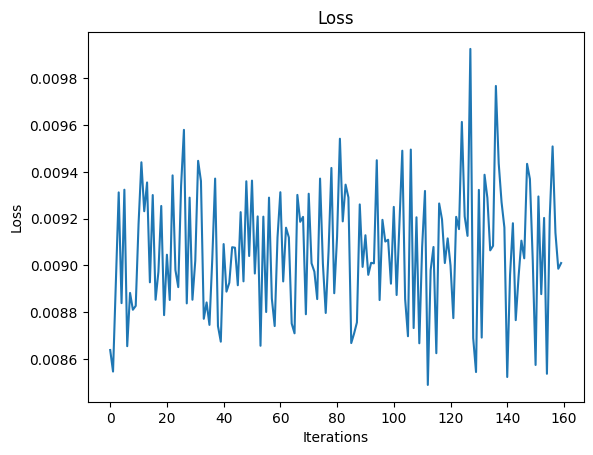

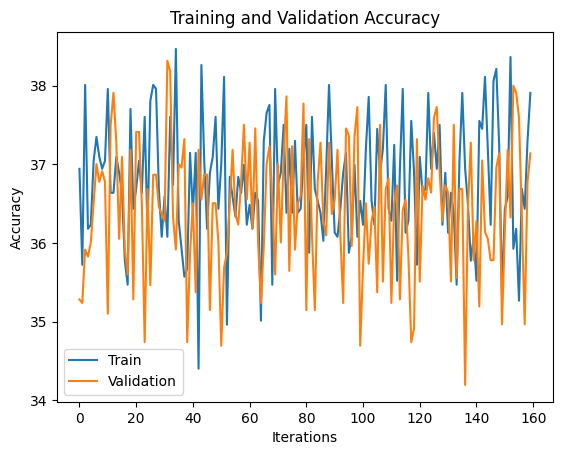

Final Training Accuracy: 37.90650406504065
Final Validation Accuracy: 37.13768115942029
Test accuracy: 34.0


In [7]:
train_adam_ce(eegclassifier1, batch_size = 127, num_epochs = 10, rate = 0.1, name = "CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample train_adam_ce")
print("Test accuracy:",get_accuracy(eegclassifier1, train = True, train_data = testloader))

Rate: 0.1
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Epoch: 0
Training Accuracy: 39.53252032520325
Validation Accuracy: 37.5
Rate: 0.1
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Epoch: 1
Training Accuracy: 38.82113821138211
Validation Accuracy: 40.85144927536232
Rate: 0.1
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Epoch: 2
Training Accuracy: 39.43089430894309
Validation Accuracy: 38.994565217391305
Rate: 0.01
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 

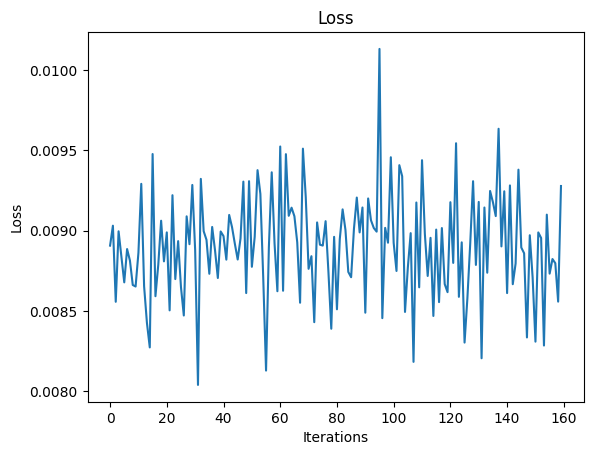

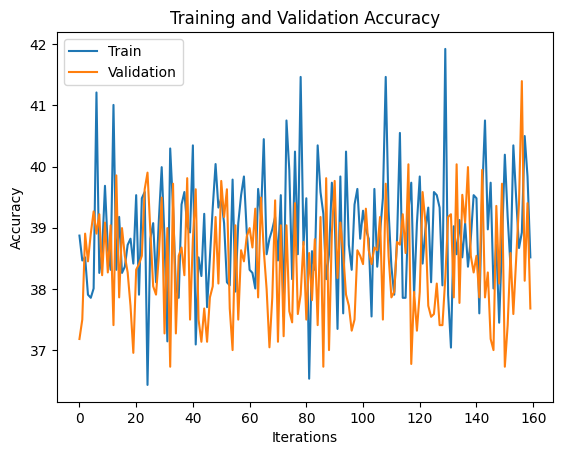

Final Training Accuracy: 38.516260162601625
Final Validation Accuracy: 37.68115942028985
Test accuracy: 35.0


In [15]:
train_adam_ce_step_lr(eegclassifier2, batch_size = 127, num_epochs = 10, rate = 0.1, name = "CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample train_adam_ce_step_lr")
print("Test accuracy:",get_accuracy(eegclassifier2, train = True, train_data = testloader))

Rate: 0.1
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Epoch: 0
Training Accuracy: 34.80691056910569
Validation Accuracy: 34.60144927536232
Rate: 0.09
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Epoch: 1
Training Accuracy: 34.75609756097561
Validation Accuracy: 34.60144927536232
Rate: 0.08
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Epoch: 2
Training Accuracy: 34.75609756097561
Validation Accuracy: 34.60144927536232
Rate: 0.07
Iteration: 49
Iteration: 50
Iteration: 

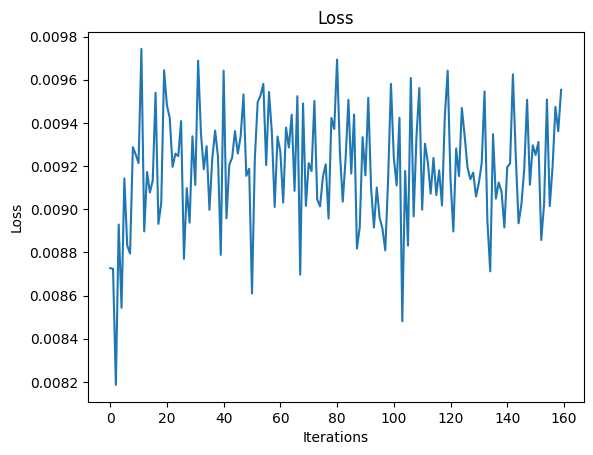

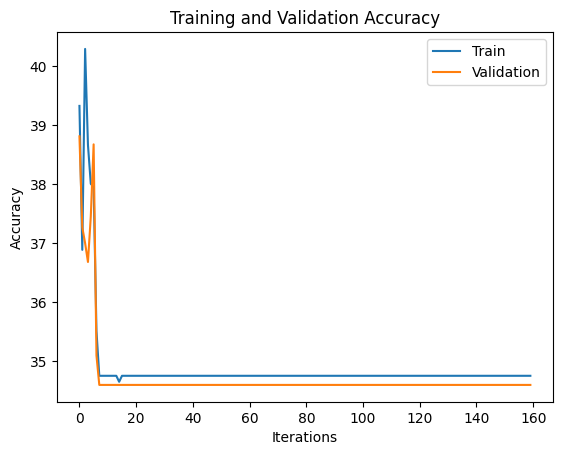

Final Training Accuracy: 34.75609756097561
Final Validation Accuracy: 34.60144927536232
Test accuracy: 35.0


In [16]:
train_adam_ce_lin_lr(eegclassifier3, batch_size = 127, num_epochs = 10, rate = 0.1, name = "CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample train_adam_ce_lin_lr")
print("Test accuracy:",get_accuracy(eegclassifier3, train = True, train_data = testloader))

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Epoch: 0
Training Accuracy: 34.146341463414636
Validation Accuracy: 33.197463768115945
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Epoch: 1
Training Accuracy: 39.88821138211382
Validation Accuracy: 36.91123188405797
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Epoch: 2
Training Accuracy: 32.926829268292686
Validation Accuracy: 32.33695652173913
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration

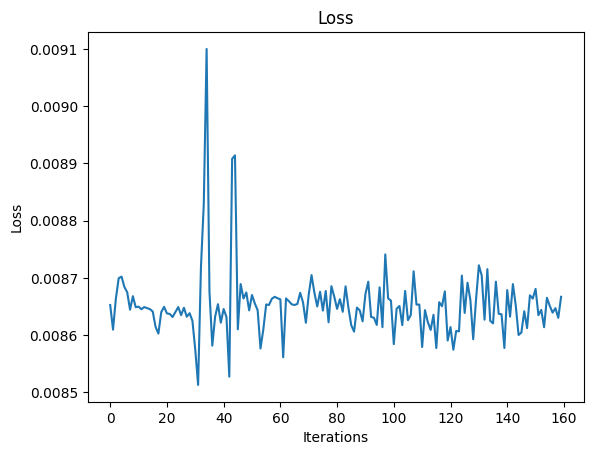

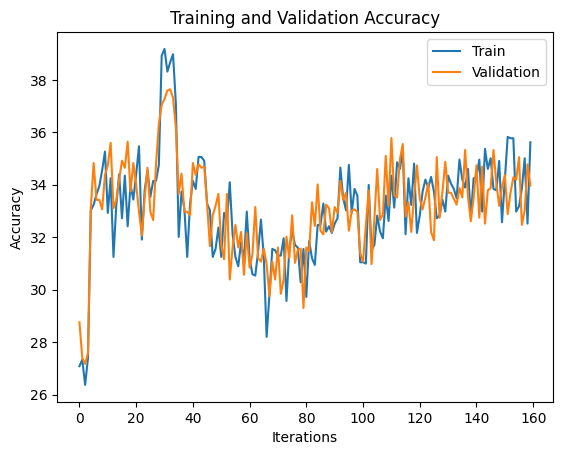

Final Training Accuracy: 35.61991869918699
Final Validation Accuracy: 33.96739130434783
Test accuracy: 26.0


In [17]:
train_sgd_ce(eegclassifier1_sgd, batch_size = 127, num_epochs = 10, rate = 0.1, name = "CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample train_sgd_ce")
print("Test accuracy:",get_accuracy(eegclassifier1_sgd, train = True, train_data = testloader))

Rate: 0.1
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Epoch: 0
Training Accuracy: 37.550813008130085
Validation Accuracy: 37.86231884057971
Rate: 0.1
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Epoch: 1
Training Accuracy: 39.27845528455285
Validation Accuracy: 38.81340579710145
Rate: 0.1
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Epoch: 2
Training Accuracy: 37.65243902439025
Validation Accuracy: 38.994565217391305
Rate: 0.01
Iteration: 49
Iteration: 50
Iteration: 

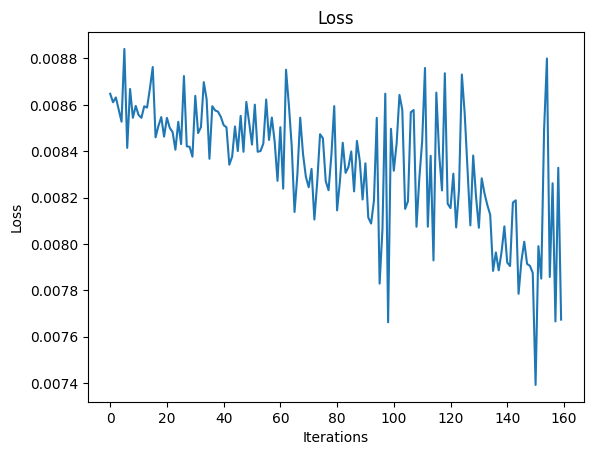

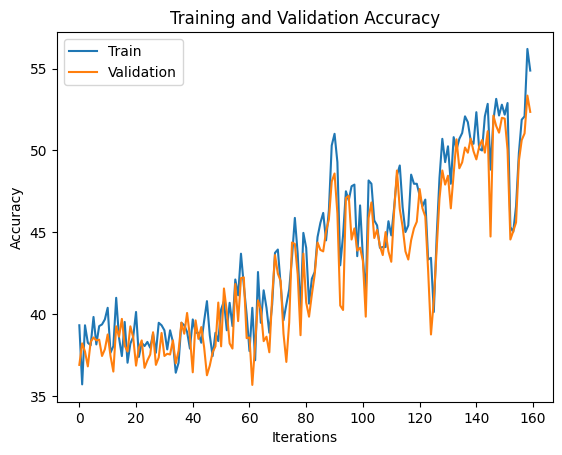

Final Training Accuracy: 54.8780487804878
Final Validation Accuracy: 52.35507246376812
Test accuracy: 31.0


In [18]:
train_sgd_ce_step_lr(eegclassifier2_sgd, batch_size = 127, num_epochs = 10, rate = 0.1, name = "CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample train_sgd_ce_step_lr")
print("Test accuracy:",get_accuracy(eegclassifier2_sgd, train = True, train_data = testloader))

Rate: 0.1
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Epoch: 0
Training Accuracy: 38.41463414634146
Validation Accuracy: 36.73007246376812
Rate: 0.09
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Epoch: 1
Training Accuracy: 39.1260162601626
Validation Accuracy: 38.58695652173913
Rate: 0.08
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Epoch: 2
Training Accuracy: 42.02235772357724
Validation Accuracy: 43.34239130434783
Rate: 0.07
Iteration: 49
Iteration: 50
Iteration: 5

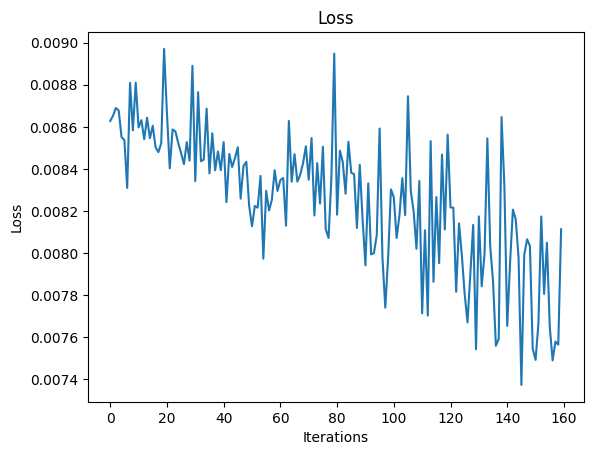

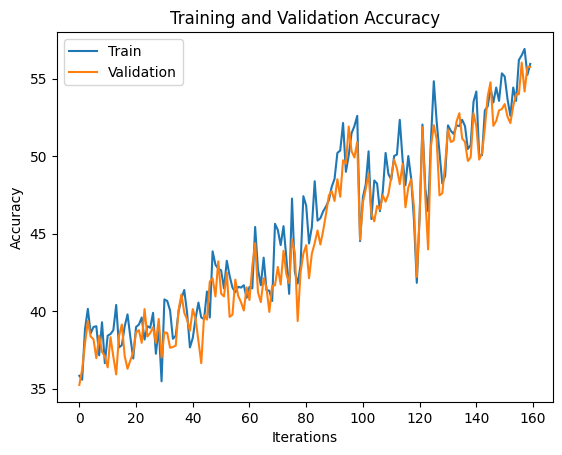

Final Training Accuracy: 55.94512195121951
Final Validation Accuracy: 55.7518115942029
Test accuracy: 37.0


In [19]:
train_sgd_ce_lin_lr(eegclassifier3_sgd, batch_size = 127, num_epochs = 10, rate = 0.1, name = "CNN_EEG_Classifier_3cnn_medium_kernel_leaky_downsample train_sgd_ce_lin_lr")
print("Test accuracy:",get_accuracy(eegclassifier3_sgd, train = True, train_data = testloader))